In [1]:
import muon as mu
import numpy as np
import scanpy as sc
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Data loading

# T commit scCITE-seq data: "../data/t_commit.h5mu"
# totalVI SNL_111: "/home/wuxinchao/data/st_cite_data/totalVI_reproducibility/data/SNL_111.h5mu"
# 10X scCITE-seq data: "../data/pbmc_10k_protein_v3_filtered_feature_bc_matrix.h5"
# Stereo CITE-seq data: "/home/wuxinchao/data/st_cite_data/sp_mudata.h5mu" B01825A4
# spatial_cite-seq data: "/home/wuxinchao/data/st_cite_data/spatial_cite_data"

In [3]:
save_path = "/home/wuxinchao/data/st_cite_data/totalVI_reproducibility/data/"
SLN_adata = ad.read(save_path + "spleen_lymph_111.h5ad")

In [4]:
spatial_cite_data_path = "/home/wuxinchao/data/st_cite_data/sp_mudata.h5mu"

In [5]:
# sc_cite_mudata = mu.read_h5mu(sc_cite_seq_data_path)
spatial_cite_mudata = mu.read_h5mu(spatial_cite_data_path)

In [6]:
# align the features of two datasets
# pre-train the model using scCITE-seq data
# fine-tune the model using spatial CITE-seq data
# objective is to infer the missing protein and RNA expression in spatial CITE-seq data compared to scCITE-seq data

# 1. Preprocess the data

In [7]:
SLN_adata

AnnData object with n_obs × n_vars = 16828 × 13553
    obs: 'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'highly_variable_mean_variance', 'encode', 'hvg_encode'
    uns: 'protein_names', 'version'
    obsm: 'protein_expression'

In [8]:
# filter the protein expression
keep_pro_111 = np.array(
    [not p.startswith("HTO") for p in SLN_adata.uns["protein_names"]]
)
SLN_adata.obsm["protein_expression"] = SLN_adata.obsm["protein_expression"][
    :, keep_pro_111
]
SLN_adata.uns["protein_names"] = SLN_adata.uns["protein_names"][keep_pro_111]
# # filter the RNA expression
# hvg_111 = SLN_adata.var["hvg_encode"]
# dataset = SLN_adata[:, hvg_111]

In [9]:
rna_data_111 = ad.AnnData(
    X=SLN_adata.X,
    obs=pd.DataFrame(index=SLN_adata.obs.index),
    var=pd.DataFrame(index=SLN_adata.var.index),
)

In [10]:
# rna_data_111.var_names_make_unique()
sc.pp.filter_cells(rna_data_111, min_genes=200)
sc.pp.filter_genes(rna_data_111, min_cells=3)
# annotate the group of mitochondrial genes as 'mt'
rna_data_111.var['mt'] = rna_data_111.var_names.str.startswith('mt-')  
sc.pp.calculate_qc_metrics(rna_data_111, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

In [11]:
len(set(rna_data_111.var_names))

13553

In [12]:
rna_data_111.layers["counts"] = rna_data_111.X.copy()

In [13]:
rna_data_111 = rna_data_111[rna_data_111.obs.n_genes_by_counts < 5000, :]
sc.pp.normalize_total(rna_data_111, target_sum=1e4)
sc.pp.log1p(rna_data_111)
sc.pp.scale(rna_data_111, max_value=10)

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


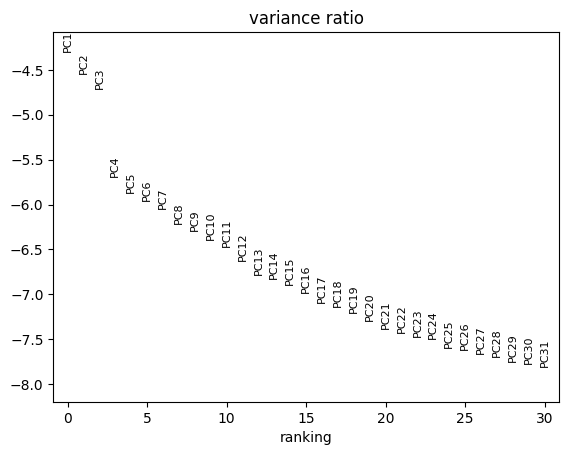

In [14]:
sc.tl.pca(rna_data_111, svd_solver='arpack')
sc.pl.pca_variance_ratio(rna_data_111, log=True)

In [15]:
sc.pp.neighbors(rna_data_111, n_neighbors=10, n_pcs=40)
sc.tl.umap(rna_data_111)

In [16]:
sc.tl.leiden(rna_data_111)

In [17]:
complete_metadata = pd.merge(rna_data_111.obs, SLN_adata.obs, left_index=True, right_index=True)

In [18]:
rna_data_111.obs = complete_metadata

In [19]:
protein_data_111 = ad.AnnData(
    X=np.array(SLN_adata.obsm["protein_expression"]),
    obs=SLN_adata.obs.copy(),
    var=SLN_adata.uns["protein_names"].copy()
)
protein_data_111.var_names = SLN_adata.uns["protein_names"]
protein_data_111.var = protein_data_111.var.drop(columns=0)

In [20]:
reassign_cluster_names = {
    "Neutrophils": "Myeloid",
    "Plasma B": "B",
    "Red-pulp macrophages": "Myeloid",
    "T doublets": "doublets",
    "Transitional B": "B",
    "Tregs": "Treg",
    "cDC1s": "DCs",
    "cDC2s": "DCs",
    "pDCs": "DCs",
    "B doublets": "doublets",
    "B-CD4 T cell doublets": "doublets",
    "B-CD8 T cell doublets": "doublets",
    "B-macrophage doublets": "doublets",
    "B1 B": "B",
    "CD122+ CD8 T": "CD8 T",
    "CD4 T": "CD4 T",
    "CD8 T": "CD8 T",
    "Cycling B/T cells": "doublets",
    "Erythrocytes": "Erythrocytes",
    "GD T": "T",
    "ICOS-high Tregs": "Treg",
    "Activated CD4 T": "CD4 T",
    "Ifit3-high B": "B",
    "Ifit3-high CD4 T": "CD4 T",
    "Ifit3-high CD8 T": "CD8 T",
    "Low quality B cells": "Low quality B",
    "Low quality T cells": "Low quality T",
    "Ly6-high mono": "Myeloid",
    "Ly6-low mono": "Myeloid",
    "MZ B": "B",
    "MZ/Marco-high macrophages": "Myeloid",
    "Mature B": "B",
    "Migratory DCs": "DCs",
    "NK": "NK",
    "NKT": "NKT",
}

In [21]:
rna_data_111.obs["combined_cell_types"] = rna_data_111.obs["cell_types"].map(reassign_cluster_names)

In [22]:
rna_data_111.obs["batch_indices"]

index
AAACCCAAGGGTAATT-1    0
AAACCCAAGGTAAACT-1    0
AAACCCACACTAGGTT-1    0
AAACCCACAGATACCT-1    0
AAACCCACAGGAATAT-1    0
                     ..
TTTGTTGGTAAGATCA-2    1
TTTGTTGGTCAGACTT-2    1
TTTGTTGGTGTTTACG-2    1
TTTGTTGTCAGAATAG-2    1
TTTGTTGTCGAGTGGA-2    1
Name: batch_indices, Length: 16814, dtype: int64

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


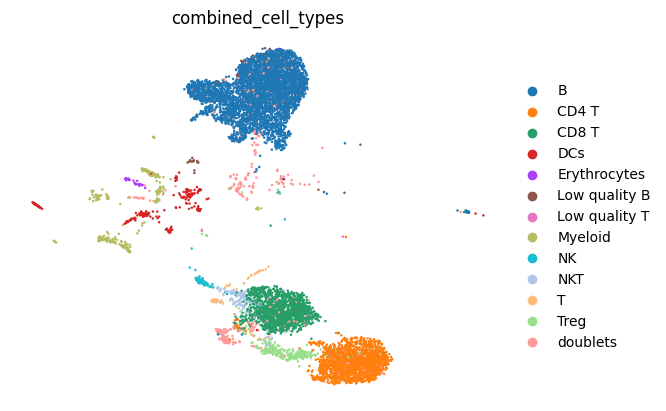

In [23]:
sc.pl.embedding(
    rna_data_111[rna_data_111.obs["batch_indices"] == 0],
    basis="X_umap",
    layer="rna_denoised",
    color=["combined_cell_types"],
    frameon=False,
    ncols=1,
)

In [24]:
mdata = mu.MuData({
    "rna": rna_data_111,
    "protein": protein_data_111,
})
mdata

MuData object with n_obs × n_vars = 16828 × 13663
  2 modalities
    rna:	16814 x 13553
      obs:	'n_genes_x', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes_y', 'percent_mito', 'leiden_subclusters', 'cell_types', 'combined_cell_types'
      var:	'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
      uns:	'log1p', 'pca', 'neighbors', 'umap', 'leiden'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'distances', 'connectivities'
    protein:	16828 x 110
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types'

In [25]:
mdata.write_h5mu(save_path + "SLN_111.h5mu")

# 2. Align the features of two datasets
Find the common features of two datasets  
Integrate the two batches of data through the GSPI

The objective is to integrate the batches of datasets that cells labeled with the same cell type are close to each other in the embedding space.

The metrics should be used to evaluate the centrality of the cells and their neighbors in the embedding space.

In [33]:
import torch
import muon as mu
from dataset import GeneVocab
from dataset import SinglecellData
from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit

save_path = "/home/wuxinchao/data/st_cite_data/totalVI_reproducibility/data/"
mdata = mu.read_h5mu(save_path + "SLN_111.h5mu")

In [34]:
mdata.mod['rna']

AnnData object with n_obs × n_vars = 16814 × 13553
    obs: 'n_genes_x', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes_y', 'percent_mito', 'leiden_subclusters', 'cell_types', 'combined_cell_types'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [27]:
gene_dict = {
    "Atn1-1": "Atn1",
    "Dancr-1": "Dancr",
    "Gbp6-1": "Gbp6",
    "Hist2h2bb-1": "Hist2h2bb",
    "Itgam-1": "Itgam",
    "Pcdhga8-1": "Pcdhga8",
    "Smim20-1": "Smim20",
    "U2af1l4-1": "U2af1l4",
}

In [28]:
rna_adata = mdata.mod["rna"]

# replace var_names using gene_dict
for k, v in gene_dict.items():
    rna_adata.var_names = rna_adata.var_names.str.replace(k, v)

In [29]:
gtf_path = "/DATA/User/wuxinchao/st_cite_data/ref/Mus_musculus.GRCm38.84.gtf"
geneVocab = GeneVocab(mdata.mod['rna'])
geneVocab.sort_by_genomic_position(gtf_path)

In [38]:
sc_rna_data = geneVocab.align_features(mdata.mod['rna'])
sc_prot_data = mdata.mod['protein'][mdata.mod['rna'].obs_names]

/DATA/User/wuxinchao/project/spatial-CITE-seq/sc_st_attention_integration/GSPI/dataset.py:83: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_new = ad.AnnData(adata_new_df.values, obs=adata_new.obs, var=adata_new_var_df)


In [40]:
sc_rna_data.obsp = mdata.mod['rna'].obsp

In [41]:
model_choice = "Graph Cross Attention"

rna_input_dim = mdata.mod['rna'].X.shape[1]
prot_input_dim = mdata.mod['protein'].X.shape[1]

hidden_dim = 32
embedding_dim = 32
heads = 4
num_blocks = 2
permute = False
preserve_rate = 0.2
alpha = 0.4
beta = 0.4

# setting for the trainer
batch_size = 256
lr = 1e-3
epochs = 50
mask_ratio = 0.85
num_splits = 2
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

scData = SinglecellData(mdata, geneVocab)

num_splits = 2
num_val = 0.2
num_test = 0.2

tsf = RandomNodeSplit(
    num_splits=num_splits, 
    num_val=num_val, 
    num_test=num_test, 
    key=None
)

training_data = tsf(scData.data)

/DATA/User/wuxinchao/project/spatial-CITE-seq/sc_st_attention_integration/GSPI/dataset.py:138: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous()


In [42]:
from train import Trainer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainer = Trainer(
    training_data,
    model_choice=model_choice, 
    rna_input_dim=rna_input_dim, 
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks, 
    batch_size=batch_size,
    lr=lr,
    epochs=epochs,
    mask_ratio=mask_ratio,
    permute=permute,
    preserve_rate=preserve_rate,
    num_splits=num_splits,
    device=device,
    alpha=alpha,
    beta=beta,
)

train_losses, val_losses = trainer.train()

Epoch 1/50 train_loss: 335978.96094 val_loss: 70714.37378
Epoch 2/50 train_loss: 195943.37183 val_loss: 51921.37915
Epoch 3/50 train_loss: 114232.48407 val_loss: 34414.95392
Epoch 4/50 train_loss: 103854.98407 val_loss: 33476.46179
Epoch 5/50 train_loss: 100277.61304 val_loss: 32808.69958
Epoch 6/50 train_loss: 87865.49097 val_loss: 27211.38037
Epoch 7/50 train_loss: 70240.55597 val_loss: 22891.38354
Epoch 8/50 train_loss: 58502.98871 val_loss: 19640.53195
Epoch 9/50 train_loss: 50702.47012 val_loss: 18915.23065
Epoch 10/50 train_loss: 47841.93439 val_loss: 17846.76501
Epoch 11/50 train_loss: 45847.78784 val_loss: 18367.99432
Epoch 12/50 train_loss: 44376.16913 val_loss: 17959.02069
Epoch 13/50 train_loss: 43588.39175 val_loss: 17477.19284
Epoch 14/50 train_loss: 42896.68484 val_loss: 17357.80957
Epoch 15/50 train_loss: 40485.08051 val_loss: 16783.55872
Epoch 16/50 train_loss: 38714.07986 val_loss: 15903.87122
Epoch 17/50 train_loss: 35461.31284 val_loss: 15237.95935
Epoch 18/50 train_

In [43]:
# save the best model parameters
save_dict = {
    "model": trainer.best_model.state_dict(),
    "optimizer": trainer.optimizer.state_dict(),
}
torch.save(save_dict, "../save_model/best_model.pt")

# 3. Transfer the scCITE-seq data to spCITE-seq data

What should be done to the spatial data?

1. Impute the missing values and infer the real values for the spatial data?
2. Impute the missing protein values and infer the real values for the spatial data?
3. Check the embedding space of the spatial data and the scCITE-seq data, and find the corresponding cells in the embedding space that are close to each other.

In [44]:
sp_data_path = "/home/wuxinchao/data/st_cite_data/"
sp_mudata = mu.read_h5mu(sp_data_path + "sp_mudata.h5mu")
rna_adata = sp_mudata.mod["rna"]
prot_adata = sp_mudata.mod["prot"]

In [45]:
rna_adata = geneVocab.align_features(rna_adata)

/DATA/User/wuxinchao/project/spatial-CITE-seq/sc_st_attention_integration/GSPI/dataset.py:83: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_new = ad.AnnData(adata_new_df.values, obs=adata_new.obs, var=adata_new_var_df)


In [49]:
prot_adata

AnnData object with n_obs × n_vars = 8628 × 10
    obsm: 'spatial'

In [54]:
mdata.mod['protein'].var_names

Index(['ADT_CD102_A0104', 'ADT_CD103_A0201', 'ADT_CD106_A0226',
       'ADT_CD115(CSF-1R)_A0105', 'ADT_CD117(c-Kit)_A0012', 'ADT_CD11a_A0595',
       'ADT_CD11c_A0106', 'ADT_CD122(IL-2Rb)_A0227', 'ADT_CD127(IL-7Ra)_A0198',
       'ADT_CD134(OX-40)_A0195',
       ...
       'ADT_TCRVr1.1-Cr4_A0209', 'ADT_TCRVr2_A0211', 'ADT_TCRVr3_A0210',
       'ADT_TCRbchain_A0120', 'ADT_TCRr-d_A0121',
       'ADT_TER-119-ErythroidCells_A0122', 'ADT_Tim-4_A0567', 'ADT_XCR1_A0568',
       'ADT_anti-P2RY12_A0415', 'ADT_integrinb7_A0214'],
      dtype='object', length=110)

In [55]:
prot_adata.var_names

Index(['mouse_rat_human_CD27_prot', 'mouse_CD11c_prot', 'mouse_CD8a_prot',
       'mouse_CD68_prot', 'mouse_CD90_2_prot', 'mouse_CD3_prot',
       'mouse_human_CD44_prot', 'mouse_CD5_prot', 'mouse_CD4_prot',
       'mouse_rat_CD29_prot'],
      dtype='object')